In [3]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from os import path as osp
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA

from retrievalnet.settings import DATA_PATH, EXPER_PATH
from utils import plot_imgs
from retrievalnet.datasets.utils.nclt_undistort import Undistort
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
root = osp.join(DATA_PATH, 'datasets/nclt/')
def get_data(seq, exper_name):
    im_poses = np.loadtxt(osp.join(root, 'pose_{}.csv'.format(seq)), 
                          dtype={'names': ('time', 'x', 'y', 'angle'),
                                 'formats': (np.int, np.float, np.float, np.float)},
                          delimiter=',', skiprows=1)
    descriptors = []
    for t in im_poses['time']:
        descriptor = np.load(osp.join(EXPER_PATH, 'outputs/{}/{}/{}.npz'.format(exper_name, seq, t)))
        if 'netvlad' not in exper_name:
            descriptor = descriptor['descriptor']
        else:
            descriptor = np.squeeze(descriptor)
        descriptors.append(descriptor)
    return im_poses, np.array(descriptors)
def norm(l):
    return np.array(l) / np.linalg.norm(l, axis=-1, keepdims=True)

In [32]:
def compute_tp_fp(ref_seq, query_seqs, exper_name, max_num_nn=20, max_dist_nn=1, mode='num',
                  proj_dim=40, distance_thresh=10, angle_thresh=np.pi/2):
    apply_pca = proj_dim != 0
    
    # Build index
    ref_poses, ref_descriptors = get_data(ref_seq, exper_name)
    if apply_pca:
        pca = PCA(n_components=proj_dim)
        ref_descriptors = norm(pca.fit_transform(norm(ref_descriptors)))
    ref_tree = cKDTree(ref_descriptors)
    
    # Build query data
    query_poses, query_descriptors = [], []
    for s in query_seqs:
        poses, descriptors = get_data(s, exper_name)
        if apply_pca:
            descriptors = norm(pca.transform(norm(descriptors)))
        query_poses.append(poses)
        query_descriptors.append(descriptors)
    query_poses = np.concatenate(query_poses, axis=0)
    query_descriptors = np.concatenate(query_descriptors, axis=0)
    
    # Build matches with reference using ground truth poses
    distances = np.linalg.norm(np.expand_dims([query_poses['x'], query_poses['y']], axis=2)
                               - np.expand_dims([ref_poses['x'], ref_poses['y']], axis=1), axis=0)
    angle_errors = np.abs(np.mod(np.expand_dims(query_poses['angle'], axis=1)
                                 - np.expand_dims(ref_poses['angle'], axis=0) + np.pi,
                                 2*np.pi) - np.pi)  # bring it in [-np.pi,+np.pi]
    gt_matches = np.logical_and(distances < distance_thresh, angle_errors < angle_thresh)
    valid = np.any(gt_matches, axis=1)
    
    if mode == 'num':
        # Query
        query_distances, idx = ref_tree.query(query_descriptors, k=max_num_nn)
        tp = gt_matches[np.expand_dims(np.arange(len(idx)), axis=1), idx]
        fp = np.logical_not(tp)
        tp_cum = np.cumsum(tp, axis=1)
        fp_cum = np.cumsum(fp, axis=1)
        return tp_cum, fp_cum, gt_matches, valid
    
    elif mode == 'dist':
        query_tree = cKDTree(query_descriptors)
        nn_indices = query_tree.query_ball_tree(ref_tree, max_dist_nn)
        descriptor_distances = []
        tp = []
        for idx, d, m in zip(nn_indices, query_descriptors, gt_matches):
            descriptor_distances.append(np.linalg.norm(np.expand_dims(d, axis=0) - ref_descriptors[idx], axis=1))
            tp.append(m[idx])
        descriptor_distances = np.concatenate(descriptor_distances, axis=0)
        tp = np.concatenate(tp, axis=0)
        fp = np.logical_not(tp)

        sort_idx = np.argsort(descriptor_distances)
        tp = tp[sort_idx]
        fp = fp[sort_idx]
        descriptor_distances = descriptor_distances[sort_idx]
        tp_cum = np.cumsum(tp)
        fp_cum = np.cumsum(fp)
        return tp_cum, fp_cum, descriptor_distances

In [6]:
def get_match_count(*arg, **kwarg):
    tp, fp, _, valid = compute_tp_fp(*arg, **kwarg)
    return np.mean(tp[valid] > 0, axis=0)

In [36]:
ref_seq = '2012-01-08'
query_seqs = ['2013-02-23', '2012-08-20']
expers = ['resnet50_delf_global-max-pool', 'netvlad',
          'mobilenet_proj-after_depth-0.35']

In [37]:
leg = {'loc': 9, 'bbox_to_anchor': (0.5, -0.2)}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# NN search run-time, recall, and dimensionality of the PCA reduction

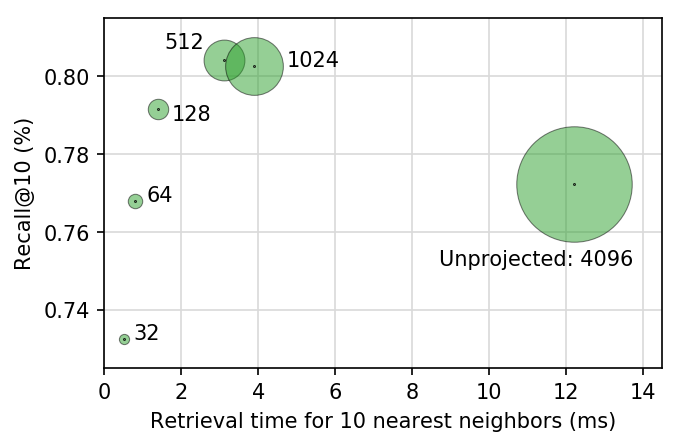

In [61]:
dims = [32, 64, 128, 512, 1024, 0]
timings = [0.5, 0.8, 1.4, 3.1, 3.9, 12.2]
annotations = ['{}'.format(d) for d in dims[:-1]] + ['Unprojected: 4096']
offsets = [(0.25, 0), (0.3, 0), (0.34, -0.003), (-1.55, 0.003), (0.84, 0), (-3.5, -0.021)]

plt.figure(figsize=(4.8, 3.2), dpi=150)
for d, t, a, o in zip(dims, timings, annotations, offsets):
    r = get_match_count(ref_seq, query_seqs, 'mobilenet_proj-after_depth-0.35', max_num_nn=10, proj_dim=d)[-1]
    plt.scatter(t, r, c=colors[2], s=(d if d != 0 else 4096)*0.75, edgecolors='k', linewidths=0.5, zorder=10, alpha=0.5)
    plt.scatter(t, r, marker='.', c='k', zorder=11, s=0.5)
    plt.annotate(a, xy=(t+o[0], r+o[1]))
plt.xlabel('Retrieval time for 10 nearest neighbors (ms)'), plt.ylabel('Recall@10 (%)');
plt.ylim(0.725, 0.815); plt.xlim(0, 14.5);
plt.grid(color=[0.85]*3); plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('plots/nclt_recall-timing_proj_v2.pdf', format='pdf')

# Recall and number of retrieved neighbors

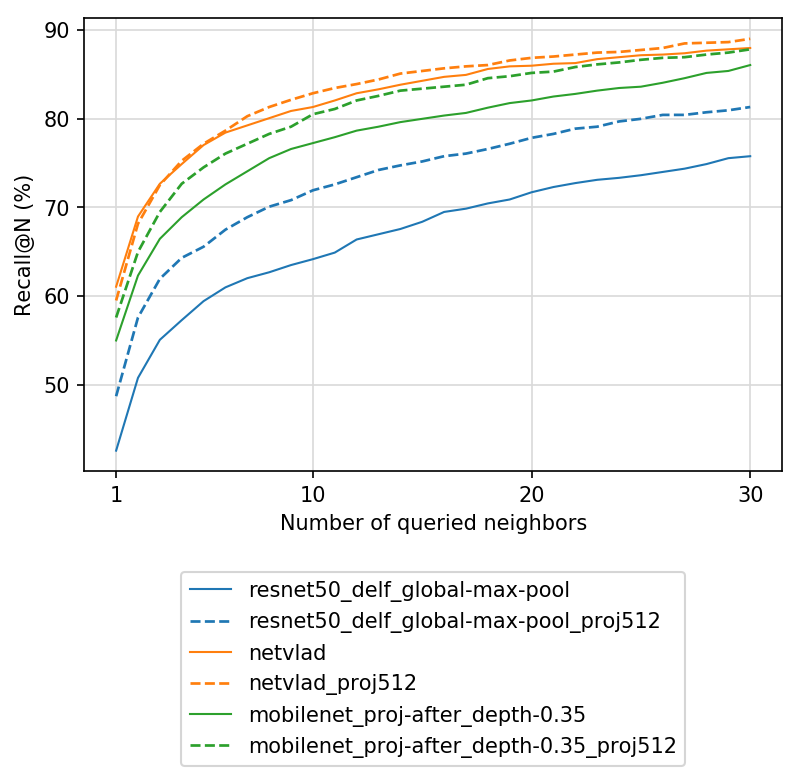

In [51]:
plt.figure(dpi=150)
for e, c in zip(expers, colors):
    m = get_match_count(ref_seq, query_seqs, e, max_num_nn=30, proj_dim=0)
    plt.plot(1+np.arange(len(m)), 100*m, label=e, color=c, linewidth=1);
    m = get_match_count(ref_seq, query_seqs, e, max_num_nn=30, proj_dim=512)
    plt.plot(1+np.arange(len(m)), 100*m, label=e+'_proj512', color=c, linewidth=1.3, linestyle='--');

plt.xticks([1]+np.arange(10, 31, step=10).tolist()); plt.grid(color=[0.85]*3);
plt.legend(**leg), plt.xlabel('Number of queried neighbors'), plt.ylabel('Recall@N (%)');
plt.savefig('plots/nclt_recall_proj512.pdf', format='pdf')